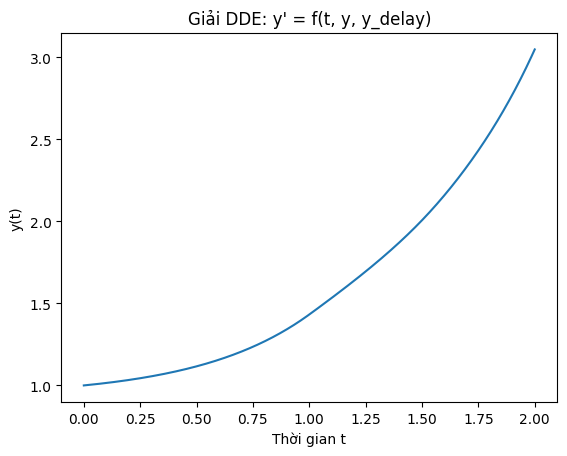

Sai số tương đối lớn nhất là:  0.3412791269630998


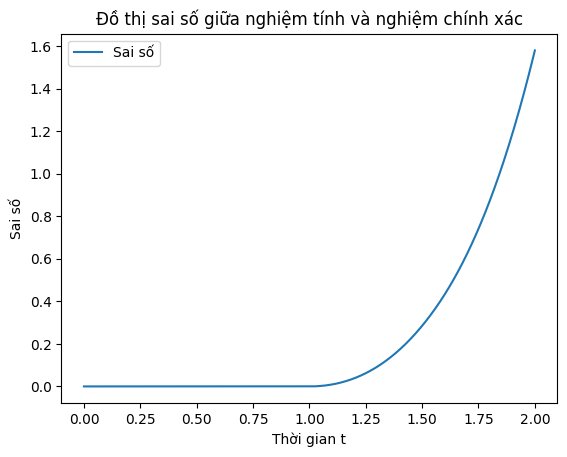

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ddeint

def f(t, y, y_delay):
        return y_delay

def tau(t, y):
        return 2-t

def phi(t):
        return np.exp(t)

# Hàm model sử dụng giá trị trễ từ hàm tau và f
def model(y, t):
    current_y = y(t)
    delay = tau(t, current_y)
    delayed_y = y(t - delay)  # Nếu (t - delay) < 0, ddeint sẽ sử dụng phi(t)
    return f(t, current_y, delayed_y)

# Xác định khoảng thời gian giải
t_values = np.linspace(0, 2, 1001)

# Giải phương trình vi phân trễ
y_values = ddeint.ddeint(model, phi, t_values)

# Vẽ đồ thị kết quả
plt.plot(t_values, y_values)
plt.xlabel('Thời gian t')
plt.ylabel('y(t)')
plt.title('Giải DDE: y\' = f(t, y, y_delay)')
plt.show()
def y_exact(t):
        """Giá trị chính xác của nghiệm cho bài toán này."""
        return 1+1/2*(np.exp(2*t-2)-np.e**-2)
y_exact_values = y_exact(t_values)

# Tính sai số tuyệt đối giữa nghiệm tính được và nghiệm chính xác
error = np.abs(y_values.flatten() - y_exact_values)
#tính sai số tương đối max
error_spce = np.abs((y_values.flatten() - y_exact_values)/y_exact_values)
error_max = np.max(error_spce)
print("Sai số tương đối lớn nhất là: ", error_max)
# Vẽ đồ thị sai số
plt.figure()
plt.plot(t_values, error, label='Sai số')
plt.xlabel('Thời gian t')
plt.ylabel('Sai số')
plt.title('Đồ thị sai số giữa nghiệm tính và nghiệm chính xác')
plt.legend()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_100\2147599811.py:45: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  k5, k6 = fsolve(equations, initial_guess)
C:\Users\Admin\AppData\Local\Temp\ipykernel_100\2147599811.py:125: RuntimeWarning: overflow encountered in scalar power
  return 2*t +y**2-t**2+y_delay-(t-1)**2
C:\Users\Admin\AppData\Local\Temp\ipykernel_100\2147599811.py:77: RuntimeWarning: invalid value encountered in scalar multiply
  y_i = y + h * sum(A[i, j] * k[j] for j in range(i))


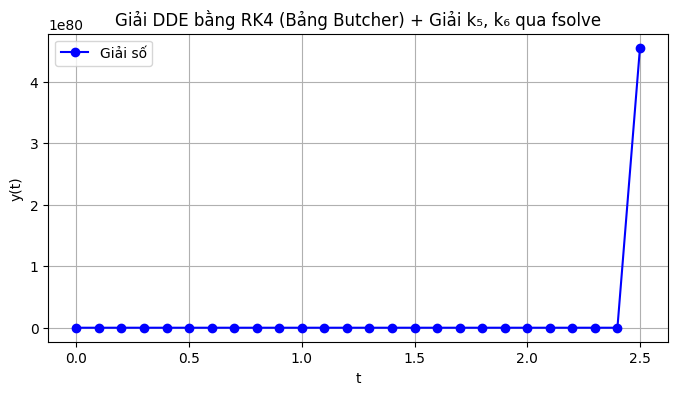

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

###############################################
# 1. Hàm nội suy lịch sử (history interpolant)
###############################################
def history_interpolant(t, t_hist, y_hist):
    """
    Nội suy tuyến tính cho giá trị lịch sử y(t) dựa trên danh sách các nút thời gian t_hist và y_hist.
    Được dùng để ước lượng y(t) khi t (có thể là thời điểm trễ) không trùng với các nút đã lưu.
    """
    if t <= t_hist[0]:
        return y_hist[0]
    elif t >= t_hist[-1]:
        return y_hist[-1]
    else:
        for i in range(len(t_hist) - 1):
            if t_hist[i] <= t < t_hist[i + 1]:
                return y_hist[i] + (y_hist[i + 1] - y_hist[i]) * (t - t_hist[i]) / (t_hist[i + 1] - t_hist[i])
    return y_hist[-1]

###############################################
# 2. Hàm giải hệ phương trình phi tuyến cho k₅ và k₆
###############################################
def compute_k5_k6(k1, k2, k3, k4):
    """
    Giả sử rằng các stage bổ sung k₅ và k₆ được xác định từ một hệ phương trình phi tuyến dựa trên 
    các điều kiện khớp nội suy liên tục (ví dụ: đảm bảo nội suy có thứ tự chính xác bậc 4).
    
    Ở đây, các điều kiện được đưa ra dưới dạng "placeholder" (tùy chỉnh lại theo yêu cầu cụ thể):
      - Ví dụ: yêu cầu giá trị nội suy tại t+h/3 phải khớp với một tổ hợp tuyến tính của k₁, k₂, k₃
      - Và tại t+2h/3 phải khớp với một tổ hợp tuyến tính của k₂, k₃, k₄.
      
    Bạn cần điều chỉnh lại biểu thức của eq1, eq2 theo điều kiện nội suy loại 2 của bạn.
    """
    def equations(x):
        k5, k6 = x
        # Đây là các biểu thức điều kiện nội suy dạng placeholder.
        eq1 = k5 - (1/3 * k1 + 1/6 * k2 + 1/6 * k3)  # Điều kiện khớp tại t + h/3 (ví dụ)
        eq2 = k6 - (1/3 * k3 + 1/6 * k2 + 1/6 * k4)  # Điều kiện khớp tại t + 2h/3 (ví dụ)
        return [eq1, eq2]
    
    initial_guess = [0, 0]  # Dự đoán ban đầu cho k5 và k6
    k5, k6 = fsolve(equations, initial_guess)
    return k5, k6

###############################################
# 3. Bước giải DDE dựa trên bảng Butcher (cho RK4)
###############################################
def rk_dde_step_with_interp(f, tau, t, y, h, butcher, t_hist, y_hist):
    """
    Thực hiện một bước giải với phương pháp Runge–Kutta dựa trên bảng Butcher đã cho.
    
    Đầu vào:
      - f: hàm số f(t, y, y_delay)
      - tau: hàm độ trễ τ(t, y)
      - t, y: thời điểm và giá trị hiện tại
      - h: bước số
      - butcher: bảng Butcher (dictionary chứa 's', 'c', 'A', 'b')
      - t_hist, y_hist: danh sách các nút thời gian và giá trị của lịch sử (dùng cho nội suy giá trị trễ)
    
    Quy trình:
      1. Tính các stage k₁, …, k₄ theo công thức của phương pháp RK4 (explicit).
      2. Từ k₁, …, k₄, giải hệ phi tuyến (sử dụng fsolve) để tìm k₅ và k₆ theo các điều kiện nội suy đã thiết lập.
      3. Tính y_next theo công thức tổng hợp của RK4.
    """
    s = butcher['s']
    c = butcher['c']
    A = butcher['A']
    b = butcher['b']
    k = np.zeros(s)
    
    # Tính các stage k₁, …, k₄ (với phương pháp explicit)
    for i in range(s):
        t_i = t + c[i] * h
        y_i = y + h * sum(A[i, j] * k[j] for j in range(i))
        t_delay = tau(t_i, y_i)
        y_delay = history_interpolant(t_delay, t_hist, y_hist)
        k[i] = f(t_i, y_i, y_delay)
    
    # Giải hệ phương trình cho k₅, k₆ (dùng các điều kiện nội suy đã thiết lập)
    k5, k6 = compute_k5_k6(k[0], k[1], k[2], k[3])
    
    # Tính giá trị y tại bước kế tiếp theo công thức của RK4
    y_next = y + h * np.sum(b * k)
    return y_next, k, k5, k6

###############################################
# 4. Bộ giải DDE sử dụng bước Runge–Kutta tổng quát theo bảng Butcher
###############################################
def solve_dde_rk_butcher(f, tau, phi, t0, tf, h, butcher):
    """
    Giải DDE:
        y'(t) = f(t, y(t), y(τ(t, y)))
    với điều kiện lịch sử y(t) = φ(t) cho t ≤ t0,
    dùng phương pháp Runge–Kutta dựa trên bảng Butcher và tính nội suy liên tục (có thêm k₅, k₆).
    """
    N = int(np.ceil((tf - t0) / h))
    t_vals = np.linspace(t0, tf, N + 1)
    y_vals = np.zeros(N + 1)
    
    # Lưu lại lịch sử (để nội suy giá trị trễ)
    t_hist = [t0]
    y_hist = [phi(t0)]
    y_vals[0] = phi(t0)
    
    for n in range(N):
        t_current = t_vals[n]
        y_current = y_vals[n]
        y_next, k, k5, k6 = rk_dde_step_with_interp(f, tau, t_current, y_current, h, butcher, t_hist, y_hist)
        y_vals[n + 1] = y_next
        
        # Cập nhật lịch sử
        t_hist.append(t_vals[n + 1])
        y_hist.append(y_next)
    
    return t_vals, y_vals

###############################################
# 5. Ví dụ định nghĩa hàm f, hàm tau và φ(t)
###############################################
def f(t, y, y_delay):
    # Ví dụ: y'(t) = -y(t) + y(t-1)
    return 2*t +y**2-t**2+y_delay-(t-1)**2

def tau(t, y):
    # Ví dụ: độ trễ τ(t, y) = t - 1 (với t < 1 dùng lịch sử)
    return 1.0

def phi(t):
    # Hàm lịch sử: ví dụ φ(t) = 1 cho t ≤ t0
    return t**2

###############################################
# 6. Bảng Butcher cho phương pháp RK4 (explicit)
###############################################
butcher_rk4 = {
    's': 4,
    'c': np.array([0.0, 0.5, 0.5, 1.0]),
    'A': np.array([
        [0.0, 0.0, 0.0, 0.0],
        [0.5, 0.0, 0.0, 0.0],
        [0.0, 0.5, 0.0, 0.0],
        [0.0, 0.0, 1.0, 0.0]
    ]),
    'b': np.array([1/6, 1/3, 1/3, 1/6])
}

###############################################
# 7. Thực thi bộ giải và vẽ đồ thị
###############################################
if __name__ == '__main__':
    t0 = 0.0
    tf = 5.0
    h = 0.1

    t_vals, y_vals = solve_dde_rk_butcher(f, tau, phi, t0, tf, h, butcher_rk4)
    
    plt.figure(figsize=(8, 4))
    plt.plot(t_vals, y_vals, 'bo-', label='Giải số')
    plt.xlabel('t')
    plt.ylabel('y(t)')
    plt.title('Giải DDE bằng RK4 (Bảng Butcher) + Giải k₅, k₆ qua fsolve')
    plt.legend()
    plt.grid(True)
    plt.show()
